# Test to Ensure GPU Functional and Available

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from  IPython import display
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn import datasets
import pandas as pd
import numpy as np
import datetime
import os
from matplotlib import pyplot as plt
import pathlib
import shutil
import tempfile
print(tf.__version__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2.1.0


__DD:__ Check to see if CUDA GPU is available:

In [2]:
tf.test.is_gpu_available(
    cuda_only=True, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

__DD:__ Try new function based on warnings:

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


__DD:__ I was wondering how to make sure GPU does the processing rather than CPU. I found the following excerpt from Tensorflow documentation:  

"If a TensorFlow operation has both CPU and GPU implementations, by default the GPU devices will be given priority when the operation is assigned to a device. For example, tf.matmul has both CPU and GPU kernels. On a system with devices CPU:0 and GPU:0, the GPU:0 device will be selected to run tf.matmul unless you explicitly request running it on another device."  

## Case Study 12

In [5]:
#os.getcwd()
#os.chdir('C:\\Users\\danie\\Documents\\GitHub\\Quantifying-The-World\\Case Study 6\\data')

__DD:__ To get the tensorflow docs packages working I had to clone the github repository to my local file system and run:  
_pip install -q C:\Users\danie\Documents\GitHub\docs_

In [6]:
#get data
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz')
FEATURES = 28
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


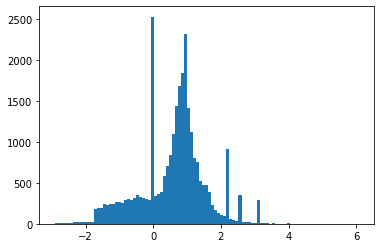

In [7]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

__DD:__ This is where we will tweek to mimic the article

In [8]:
#2.5 million train and 100000 validation as per article
#Batch suze = 1000 per article's Github

N_VALIDATION = int(100000)
N_TRAIN = int(2500000)
BUFFER_SIZE = int(2500000)
BATCH_SIZE = 1000
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [9]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [10]:
reproduced_model = tf.keras.Sequential([
    layers.Dense(300, activation='tanh', input_shape=(FEATURES,)),
#    layers.Dense(300, activation='tanh', input_shape=(FEATURES,)),
#    layers.Dense(300, activation='tanh'),
#    layers.Dense(300, activation='tanh'),
    layers.Dense(1)
])
reproduced_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               8700      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 9,001
Trainable params: 9,001
Non-trainable params: 0
_________________________________________________________________


In [11]:
reproduced_model.compile(
    optimizer='Adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.losses.BinaryCrossentropy(from_logits=True,name='binary_crossentropy')])

In [13]:
reproduced_model.fit(train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=1000,
    validation_data=validate_ds,
    verbose=0
)

In [14]:
reproduced_model.evaluate(validate_ds)

    100/Unknown - 0s 2ms/step - loss: 0.4943 - binary_crossentropy: 0.4943

[0.4942735177278519, 0.49427336]

In [ ]:
#started at 4:11 finished sometime around 5:45
